<a href="https://www.kaggle.com/code/suyashkumarbhagat/brain-tumour-detection-using-attention?scriptVersionId=185963849" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [3]:
import tensorflow as tf

def create_mri_dataset(data_dir, img_height, img_width, batch_size):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=data_dir,
        labels="inferred",
        label_mode="binary",
        validation_split=0.1,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=data_dir,
        labels="inferred",
        label_mode="binary",
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    
    return train_ds, val_ds

data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
img_height = 512
img_width = 512
batch_size = 16

train_ds, val_ds = create_mri_dataset(data_dir, img_height, img_width, batch_size)

Found 253 files belonging to 2 classes.
Using 228 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.


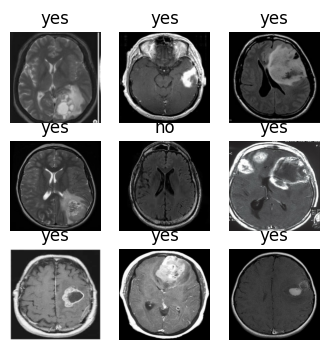

In [4]:
import matplotlib.pyplot as plt

def plot_images_from_dataset(dataset, class_names, num_images=9):
    image_batch, label_batch = next(iter(dataset))


    num_rows = num_cols = int(num_images**0.5)

    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = int(label_batch[i])
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()


class_names = ["no", "yes"]
plot_images_from_dataset(train_ds, class_names, num_images=9)

In [5]:
def attention_block(inputs):
    attention = layers.Conv2D(128, kernel_size=1, padding='same')(inputs)
    attention = layers.Activation('relu')(attention)
    attention = layers.Conv2D(128, kernel_size=1, padding='same')(attention)
    attention = layers.Activation('sigmoid')(attention)
    output = layers.multiply([inputs, attention])
    return output

In [6]:
from tensorflow.keras import layers, models

def create_model(img_height, img_width):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = layers.Rescaling(1./255)(inputs)
    
    # First Conv Block
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Second Conv Block
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Third Conv Block with Attention
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)
    
    # Fourth Conv Block with Attention
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = attention_block(x)
    
    # Flatten and Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_model(img_height, img_width)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 510, 510,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 255, 255,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 126, 126,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 62, 62,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │     16,512 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 62, 62,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 62, 62,    │     16,512 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 62, 62,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 62, 62,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │    147,584 │ multiply[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │     16,512 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 30,    │          0 │ conv2d_6[0][0]  

 Total params: 59,454,145 (226.80 MB)

 Trainable params: 59,454,145 (226.80 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 6:50 29s/step - accuracy: 0.5000 - loss: 0.6931

I0000 00:00:1719603809.512174     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719603809.536134     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.5953 - loss: 0.6727

W0000 00:00:1719603821.641057     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719603822.558515     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5967 - loss: 0.6704 - val_accuracy: 0.5800 - val_loss: 0.7009
Epoch 2/20
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.5625 - loss: 0.5554

W0000 00:00:1719603825.261660     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.6994 - loss: 0.5654 - val_accuracy: 0.8000 - val_loss: 0.8544
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7990 - loss: 0.5923 - val_accuracy: 0.8000 - val_loss: 0.4769
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.8235 - loss: 0.4535 - val_accuracy: 0.8400 - val_loss: 0.5066
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8863 - loss: 0.2845 - val_accuracy: 0.8600 - val_loss: 0.3375
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8959 - loss: 0.2378 - val_accuracy: 0.9600 - val_loss: 0.1333
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.8934 - loss: 0.2818 - val_accuracy: 0.8200 - val_loss: 0.3485
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9073 - loss: 0.2629 - val_accuracy: 0.8400 - val_loss: 0.3192
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9325 - loss: 0.1949 - val_accuracy: 0.9000 - val_

In [8]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9757 - loss: 0.4190
Validation Accuracy: 96.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


W0000 00:00:1719604660.411263     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


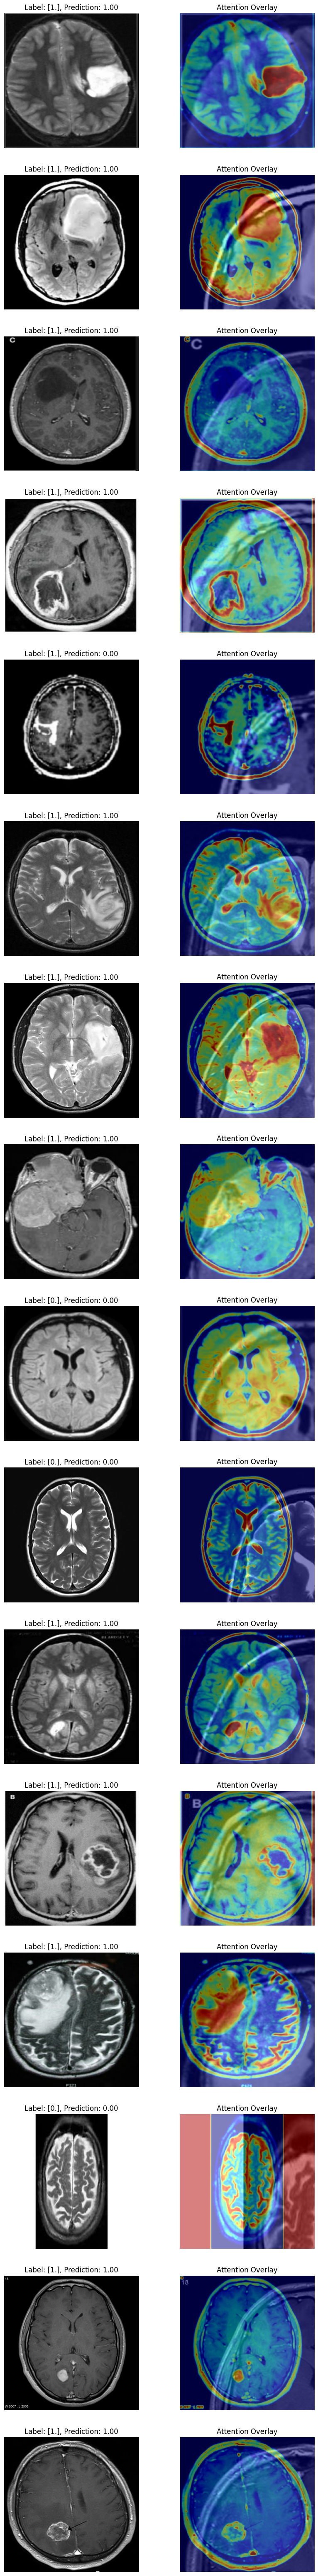

In [13]:
import numpy as np
def visualize_attention(model, val_ds, attention_layer_name='conv2d_3'):
    attention_model = models.Model(inputs=model.input, 
                                   outputs=[model.get_layer(attention_layer_name).output, model.output])
    
    # Get a batch of images and labels from the validation dataset
    for images, labels in val_ds.take(1):
        attention_maps, predictions = attention_model.predict(images)
        
        # Rescale attention maps to [0, 1] for visualization
        attention_maps = np.mean(attention_maps, axis=-1)
        attention_maps -= attention_maps.min()
        attention_maps /= attention_maps.max()
        
        num_images = len(images)
        fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images*5))
        
        for i in range(num_images):
            ax1, ax2 = axes[i]
            ax1.imshow(images[i].numpy().astype("uint8"))
            ax1.set_title(f'Label: {labels[i].numpy()}, Prediction: {predictions[i][0]:.2f}')
            ax1.axis('off')
            
            ax2.imshow(images[i].numpy().astype("uint8"))
            ax2.imshow(attention_maps[i], cmap='jet', alpha=0.5)
            ax2.set_title('Attention Overlay')
            ax2.axis('off')
        
        plt.show()
        break

visualize_attention(model, val_ds, attention_layer_name='conv2d_1')

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history)